Возможные области применения ML:

- Определение высоты тона, 
- распознавание речи, 
- понимание музыкальных инструментов, 
- создание музыки 
- др.

Разница между Аудио и Озвучиванием

То, что вы слышите, - это звуки. Звуковая волна на самом деле является передаваемой вибрацией. Частоты, скорость, громкость и направление - это особые аспекты звука.

Только частота и амплитуда являются решающими характеристиками в этой области, где в основном используется машинное обучение.

Синусоидальные волны - это обычное упрощение звуковых волн. Синусоидальная волна демонстрирует, как амплитуда переменной изменяется с течением времени. Звук записывается с помощью микрофона и преобразуется в электронное представление.

Звук представлен электронным способом с помощью аудио. Звуки с частотами от 20 Гц до 20 кГц, которые могут быть услышаны людьми.

Люди не могут слышать частоты ниже 20 Гц или выше 20 кГц, потому что они либо слишком низкие, либо слишком высокие.

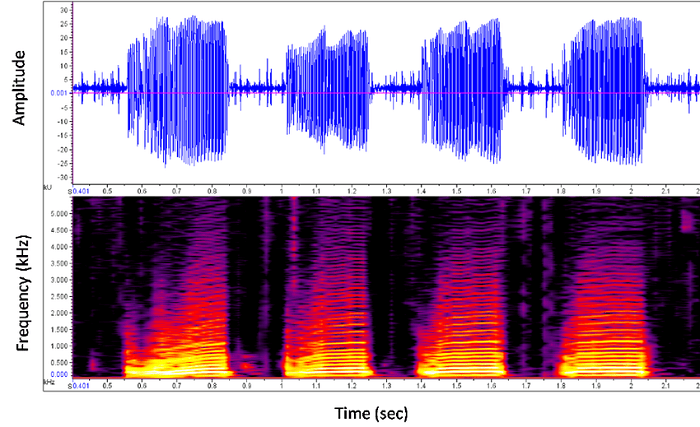

## Спектрограмма

Визуальное отображение всех частот во времени представляет собой спектрограмму.

Шкала времени указана по оси X, а частота в герцах - по оси Y. Размер или амплитуда показаны с помощью оттенка. Цвет спектрограммы измеряется в децибелах и является либо более ярким, либо более высоким (единица измерения).

Сигнал может быть преобразован в спектрограмму. Технически это сравнимо с изображением. Исследователи обнаружили, что методы компьютерного зрения могут быть успешно использованы на спектрограммах.

Это означает, что методы, используемые для классификации изображений, могут также использоваться для оценки звука. Модель машинного обучения может извлекать доминирующий звук за каждый временной кадр в форме сигнала путем определения паттернов на спектрограмме.

Однако мы не будем искать шаблоны с помощью спектрограммы. Для этого мы будем использовать библиотеку под названием Librosa.

Теперь мы это внедрим.

# Импорт библиотек

In [1]:
import sys 
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import librosa
import librosa.display

import IPython.display as ipd

In [7]:
sys.path.append('D:/Programming/Python')

In [8]:
from tools import show_correlation, export2, rounding
from decorators import timeit
from ml_tools import pairplot, training_plot, predictions_plot

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(f'tensorflow.__version__: {tf.__version__}')


tensorflow.__version__: 2.15.0


# Импорт данных

In [10]:
os.listdir()

['audios',
 'checkpoints',
 'exports',
 '.git',
 'urban_sounds_classification.ipynb',
 'gender_recognition_by_voice']

In [11]:
datas_path = 'audios'

In [12]:
os.listdir(datas_path)

['fold5',
 'fold6',
 'fold7',
 'fold8',
 'fold9',
 'fold10',
 'urban_sounds.csv',
 'fold1',
 'fold2',
 'fold3',
 'fold4']

In [13]:
while True:
    folder = np.random.choice(os.listdir(datas_path))
    if not os.path.isfile(folder): 
        random_audio_path = f'{datas_path}/{folder}/'  + np.random.choice(os.listdir(datas_path + '/' + folder))
        break
random_audio_path

'audios/fold5/72259-1-10-7.wav'

In [14]:
audio_data, sampling_rate = librosa.load(random_audio_path)
ipd.Audio(random_audio_path)

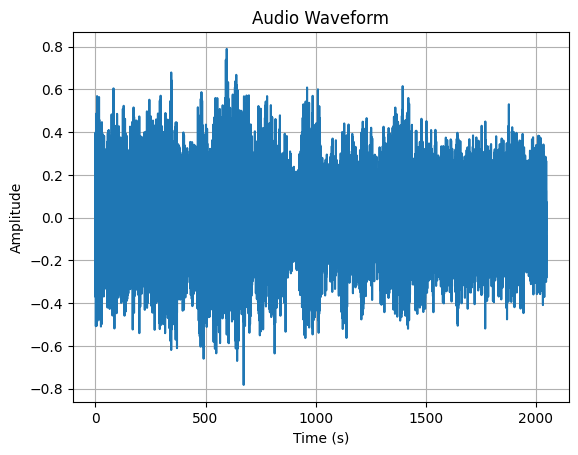

In [15]:
# Calculate the duration of the audio file
duration = len(audio_data) / sampling_rate

# Create a time array
time = librosa.times_like(audio_data, sr=sampling_rate)

# Plot the audio waveform
plt.plot(time, audio_data)
plt.grid()
# Add a title and labels
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Show the plot
plt.show()

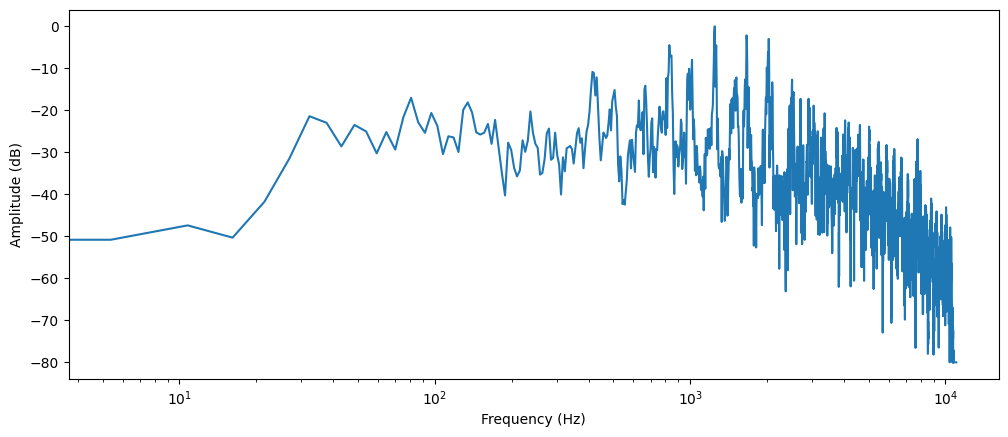

In [16]:
dft_input = audio_data[:4096]

# Рассчитаем ДПФ
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# получим амплитудный спектр в децибелах
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# получим частотные столбцы
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

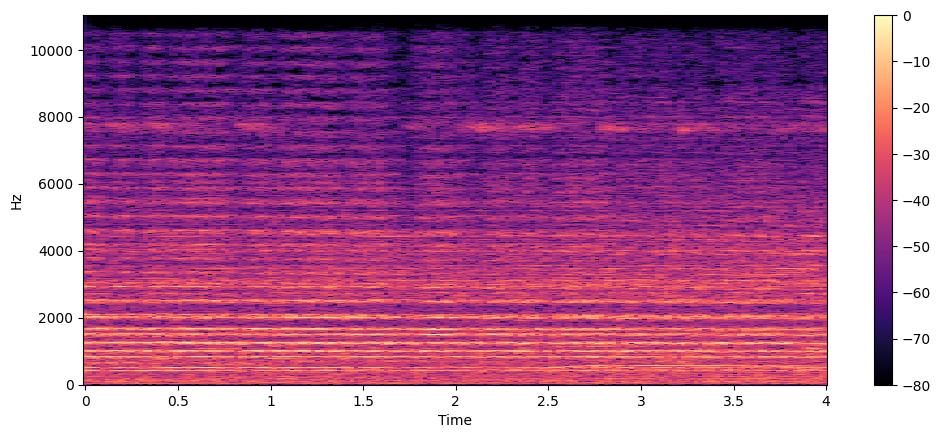

In [17]:
D = librosa.stft(audio_data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show();

В mono есть только один сигнал. Как следствие, наши данные аудиоданных демонстрируют, что Librosa преобразовала звук в одномерные целые числа.

У нас было бы два сигнала и 2D-массив, если бы это было стерео. Стереозвук обычно предпочитают в аудио. Однако в нашей статье мы не будем использовать стереосигналы.

Librosa преобразовывает эти сигналы в mono для упрощения обработки. Это дает нам ощущение ориентации, перспективы и пространства.

In [18]:
audio_data

array([-0.20032835, -0.3707707 , -0.32426232, ..., -0.24536768,
       -0.17547503, -0.05542678], dtype=float32)

In [19]:
sampling_rate

22050

In [20]:
metadata=pd.read_csv(datas_path + '/' + 'urban_sounds.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [21]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Результаты показывают, что большинство классов набора данных сбалансированы. В результате использование этого набора данных было бы разумным.

Мы пришли к выводу, что после завершения EDA эти данные представлены в формате raw. Для извлечения полезных характеристик из этих данных требуется предварительная обработка.

Вместо того чтобы использовать данные в их первоначальном виде для обучения, мы будем использовать эти производные характеристики.

# Обработка данных

Для извлечения признаков мы будем использовать метод кепстральных коэффициентов малой частоты (MFCC).

Распределение частот по размеру окна суммируется методом MFCC. Это позволяет анализировать частотные и временные свойства данного звука. Мы можем использовать его для поиска характеристик для категоризации.

Количество возвращаемых MFCC указывается аргументом n mfcc. Для нашего сценария мы выбрали 40. Можно выбрать любое значение, которое вы пожелаете.

In [22]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
mfccs

array([[-47.3239    , -33.63257   , -46.54282   , ..., -52.409035  ,
        -55.570805  , -73.37578   ],
       [ 90.106705  ,  81.05786   ,  74.24389   , ...,  90.21419   ,
         94.61336   ,  93.91757   ],
       [-47.462223  , -45.14718   , -44.212704  , ..., -51.05316   ,
        -44.40115   , -49.411522  ],
       ...,
       [-20.788792  , -27.385733  , -30.859406  , ..., -13.718097  ,
        -17.548641  , -22.299728  ],
       [  0.44511133,  -5.62614   ,  -9.529755  , ...,   0.4685832 ,
         -3.30181   ,  -3.9738975 ],
       [ 22.197052  ,  24.433674  ,  21.105173  , ...,  16.048357  ,
         16.130459  ,  14.116266  ]], dtype=float32)

Основываясь на свойствах частоты и синхронизации аудиоклипа, эти шаблоны были выведены из него.

In [23]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [24]:
features_extractor(random_audio_path)

array([-5.85345001e+01,  8.60450745e+01, -4.81528473e+01,  1.80831184e+01,
       -1.98863544e+01,  8.03237343e+00,  7.82899797e-01,  1.80984163e+00,
       -1.14699764e+01,  5.16278124e+00, -3.18292212e+00,  1.10351956e+00,
       -7.98589611e+00,  1.20120802e+01,  5.77905178e+00,  9.31424522e+00,
        8.36622810e+00,  6.00374174e+00, -4.90369558e+00,  5.06683514e-02,
       -4.17461205e+00, -1.42467165e+01, -5.51902866e+00,  3.08545160e+00,
        1.18482387e+00, -7.79418945e+00, -1.22861652e+01,  1.47010698e+01,
        1.64461727e+01, -4.81474447e+00, -2.74488964e+01,  2.52013063e+00,
        1.44879255e+01,  1.17671671e+01, -2.01227164e+00,  6.32989836e+00,
       -8.04036903e+00, -2.05005608e+01, -5.20634079e+00,  1.92745762e+01],
      dtype=float32)

Мы создаем список, содержащий все собранные функции, после извлечения функций из каждого аудиофайла в наборе данных.

После этого мы повторно просматриваем каждый аудиофайл и используем кепстральные коэффициенты малой частоты для извлечения признаков.

In [26]:
extracted_features = []
for i, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(datas_path), 
                             'fold'+str(row["fold"]) + '/', 
                             str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data, final_class_labels])

3549it [00:41, 75.12it/s] c:\Python\Python 3.11.8\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8314it [01:35, 101.54it/s]c:\Python\Python 3.11.8\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Python\Python 3.11.8\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [01:40, 87.04it/s] 


In [27]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head(10)

,feature,class
0,"[-211.93698, 62.581207, -122.81315, -60.745293...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.19586, ...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing
5,"[-441.0859, 108.92061, -25.777704, 47.518364, ...",children_playing
6,"[-469.41965, 109.28011, -18.456553, 46.043015,...",children_playing
7,"[-457.14645, 106.52766, -19.124525, 39.871788,...",children_playing
8,"[-466.2641, 118.13225, -29.881447, 50.494637, ...",children_playing
9,"[-188.62563, 102.429115, -2.3306007, -10.94615...",car_horn


In [28]:
x=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
x.shape

(8732, 40)

In [29]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# Разделение данных на тренировочные и тестовые

In [30]:
x_train, x_test, y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=0)

# Создание модели

In [31]:
num_labels=y.shape[1]
num_labels

10

Мы будем укладывать наши слои по порядку. Это проблема многоклассовой классификации, следовательно, последний слой будет содержать слой активации softmax.

In [33]:
model=Sequential()

#first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               4100      
                                                                 
 activation_4 (Activation)   (None, 100)               0         
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               20200     
                                                                 
 activation_5 (Activation)   (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy', 'mae', 'mse'])

# Обучение модели

In [41]:
epochs = 200
batch_size = 32
verbose = True

monitor = 'loss' # что мониторить
min_delta = 0.01 # сравнивать с каким значением
patience = 5 # в течении скольких эпох

callbacks = [EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             ModelCheckpoint(monitor=monitor, filepath='checkpoints/model_{epoch:d}.keras', save_best_only=True, verbose=verbose)]

In [42]:
history = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=epochs,
          batch_size=batch_size, 
          callbacks=callbacks, 
          verbose=verbose)

Epoch 1/200
219/219 [==============================] - ETA: 0s - loss: 11.0750 - accuracy: 0.1099 - mae: 0.1779 - mse: 0.1322
Epoch 1: loss improved from inf to 11.07498, saving model to checkpoints\model_1.keras
219/219 [==============================] - 2s 5ms/step - loss: 11.0750 - accuracy: 0.1099 - mae: 0.1779 - mse: 0.1322 - val_loss: 2.2898 - val_accuracy: 0.1168 - val_mae: 0.1797 - val_mse: 0.0897
Epoch 2/200
219/219 [==============================] - ETA: 0s - loss: 2.5342 - accuracy: 0.1188 - mae: 0.1788 - mse: 0.0932
Epoch 2: loss improved from 11.07498 to 2.53420, saving model to checkpoints\model_2.keras
219/219 [==============================] - 1s 3ms/step - loss: 2.5342 - accuracy: 0.1188 - mae: 0.1788 - mse: 0.0932 - val_loss: 2.2793 - val_accuracy: 0.1179 - val_mae: 0.1794 - val_mse: 0.0896
Epoch 3/200
212/219 [============================>.] - ETA: 0s - loss: 2.3456 - accuracy: 0.1179 - mae: 0.1788 - mse: 0.0904
Epoch 3: loss improved from 2.53420 to 2.34475, saving 

"d:\Programming\projects\ML\audios\classification/exports/training_plot.png" file has created!
"export2" elapsed 1.1596 seconds


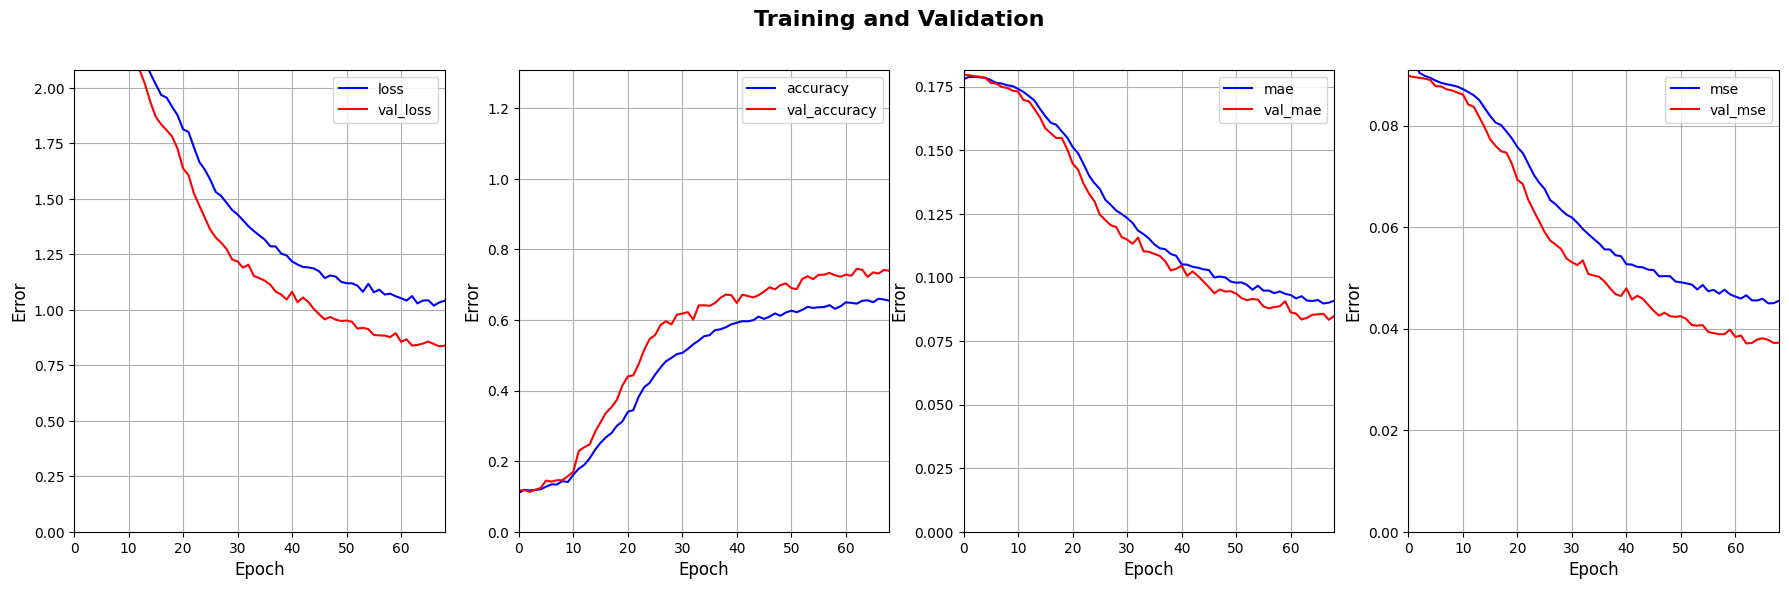

In [43]:
training_plot(history, figsize=(22, 6), savefig=True)

In [44]:
test_accuracy=model.evaluate(x_test, y_test, verbose=0)
print(test_accuracy[1])

0.7389811277389526


In [45]:
predict_x = model.predict(x_test)
classes_x=np.argmax(predict_x, axis=1)

predict_x

55/55 [==============================] - 0s 1ms/step


array([[7.63690751e-03, 6.66634529e-04, 9.27582150e-04, ...,
        1.08290362e-04, 1.11520814e-04, 9.10957623e-03],
       [1.22531597e-20, 5.32328966e-04, 2.91957519e-07, ...,
        7.65207346e-08, 3.53334112e-10, 1.05890658e-05],
       [9.43897321e-11, 6.44515734e-03, 1.66320769e-05, ...,
        1.02349964e-03, 2.13617786e-05, 2.18126387e-03],
       ...,
       [2.71755653e-06, 8.38737786e-01, 3.02669534e-04, ...,
        3.87356180e-04, 1.79916635e-04, 1.40895024e-01],
       [2.22520992e-01, 1.26820682e-02, 2.80171484e-01, ...,
        4.37119268e-02, 2.60832813e-02, 2.27998957e-01],
       [3.79579544e-01, 1.22812465e-02, 1.50635511e-01, ...,
        1.29870409e-02, 3.82568352e-02, 1.16015308e-01]], dtype=float32)

In [46]:
classes_x

array([5, 4, 4, ..., 1, 2, 0], dtype=int64)

In [50]:
filename="audios/fold8/103076-3-0-0.wav"
audio, sample_rate = librosa.load(filename)
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

[-4.3579456e+02  5.7867908e+01 -3.1872954e+00 -1.9904032e+01
 -2.0641861e+01 -2.2496645e+01 -1.9619402e+01 -1.1440506e+01
 -9.8861074e+00  4.3746150e-01  3.6107078e+00  1.3495114e+00
  1.5682597e+00  3.3248963e+00  5.3259506e+00  1.6191692e+00
 -3.5303676e+00 -3.6765375e+00 -6.3732409e+00 -8.6413746e+00
 -8.3451672e+00 -4.6818123e+00 -2.0709703e+00  2.4145410e+00
  1.8110498e+00 -1.0843938e-01 -3.1374378e+00 -3.4383008e+00
 -4.1745181e+00 -3.9663997e+00 -3.1244626e+00  5.3930396e-01
 -6.3234121e-01  1.0686828e+00  1.1267065e+00  2.1163015e+00
  1.3684056e+00  7.9674971e-01  2.0303579e-01 -7.3811364e-01]
(40,)


In [51]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

[[-4.3579456e+02  5.7867908e+01 -3.1872954e+00 -1.9904032e+01
  -2.0641861e+01 -2.2496645e+01 -1.9619402e+01 -1.1440506e+01
  -9.8861074e+00  4.3746150e-01  3.6107078e+00  1.3495114e+00
   1.5682597e+00  3.3248963e+00  5.3259506e+00  1.6191692e+00
  -3.5303676e+00 -3.6765375e+00 -6.3732409e+00 -8.6413746e+00
  -8.3451672e+00 -4.6818123e+00 -2.0709703e+00  2.4145410e+00
   1.8110498e+00 -1.0843938e-01 -3.1374378e+00 -3.4383008e+00
  -4.1745181e+00 -3.9663997e+00 -3.1244626e+00  5.3930396e-01
  -6.3234121e-01  1.0686828e+00  1.1267065e+00  2.1163015e+00
   1.3684056e+00  7.9674971e-01  2.0303579e-01 -7.3811364e-01]]
(1, 40)


In [52]:
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)

1/1 [==============================] - 0s 41ms/step
[[3.3249692e-14 3.5435189e-06 3.6437917e-04 9.5011854e-01 7.8330742e-04
  4.7509739e-11 4.7395688e-02 4.2080438e-16 1.1802407e-03 1.5433069e-04]]


In [53]:
classes_x=np.argmax(predicted_label, axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class

array(['dog_bark'], dtype='<U16')